## Bayesian Linear Regression

In [164]:
%pip install pymc pytensor

In [165]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

### Exercise: Simple Linear Regression

In [96]:
np.random.seed(123)

N = 100
x = np.random.normal(10,1,N)
eps = np.random.normal(0,0.5,size=N)

alpha_real = 2.5
beta_real = 0.9

y_real = alpha_real + beta_real*x

y = y_real + eps

print(f"x, {x[: 5]}, ... {x[-2 :]}")
print(f"y, {y[: 5]}, ... {y[-2 :]}")

"""
# what happens if you center your data around the origin?
y = y - np.mean(y)
x = x - np.mean(x)
y_real = y_real - np.mean(y_real)
"""

x, [ 8.9143694  10.99734545 10.2829785   8.49370529  9.42139975], ... [10.37940061  9.62082357]
y, [10.8439598  11.40866694 12.11081297 11.44348672 10.96694678], ... [11.67082969 11.04976808]


'\n# what happens if you center your data around the origin?\ny = y - np.mean(y)\nx = x - np.mean(x)\ny_real = y_real - np.mean(y_real)\n'

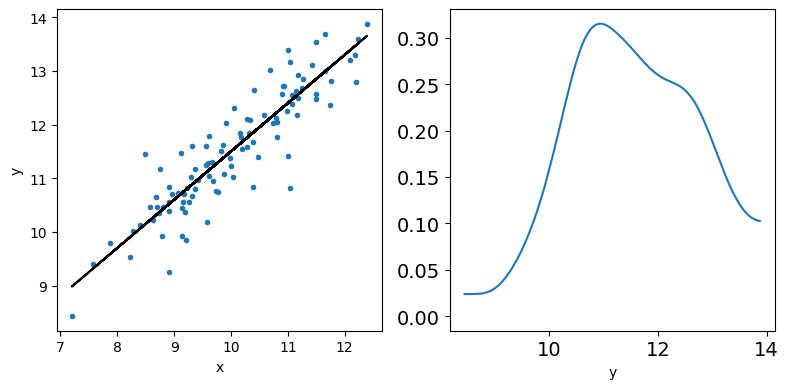

In [97]:
_, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(x,y,'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].plot(x,y_real,'k')
az.plot_kde(y,ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

In [98]:
with pm.Model() as model_lin:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)

    # Deterministic nodes are computed outside the main computation graph,
    # which can be optimized as though there was no Deterministic nodes.
    # Whereas the optimized graph can be evaluated thousands of times during a NUTS step,
    # the Deterministic quantities are just computeed once at the end of the step,
    # with the final values of the other random variables

    y_pred = pm.Normal('y_pred', mu=α + β * x, sigma=ϵ, observed=y)

    trace_lin = pm.sample(1000, tune=1000)

array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'ϵ'}>, <Axes: title={'center': 'ϵ'}>]],
      dtype=object)

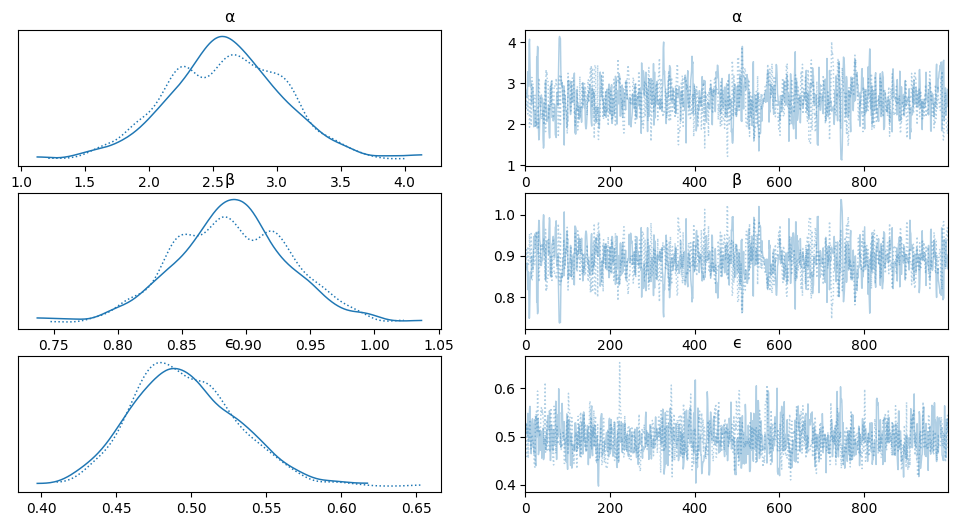

In [100]:
az.plot_trace(trace_lin, var_names=['α', 'β', 'ϵ'])

In [101]:
az.summary(trace_lin)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.603,0.455,1.779,3.478,0.018,0.013,671.0,576.0,1.0
β,0.889,0.045,0.802,0.970,0.002,0.001,665.0,721.0,1.0
ϵ,0.496,0.035,0.431,0.559,0.001,0.001,925.0,913.0,1.0
μ[0],10.526,0.071,10.395,10.658,0.002,0.002,936.0,1142.0,1.0
μ[1],12.377,0.064,12.263,12.503,0.002,0.001,989.0,1288.0,1.0
...,...,...,...,...,...,...,...,...,...
μ[95],12.407,0.065,12.290,12.533,0.002,0.001,972.0,1221.0,1.0
μ[96],10.527,0.070,10.396,10.659,0.002,0.002,937.0,1142.0,1.0
μ[97],10.279,0.080,10.128,10.422,0.003,0.002,860.0,1028.0,1.0
μ[98],11.828,0.050,11.730,11.917,0.001,0.001,1490.0,1530.0,1.0


<Axes: xlabel='α', ylabel='β'>

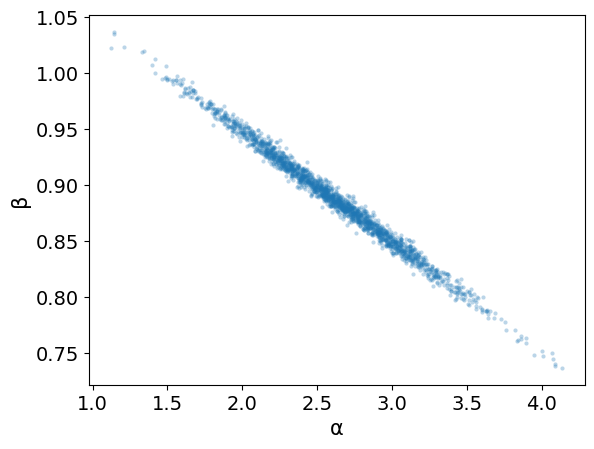

In [102]:
az.plot_pair(trace_lin,var_names=['α','β'], scatter_kwargs={'alpha': 0.3})

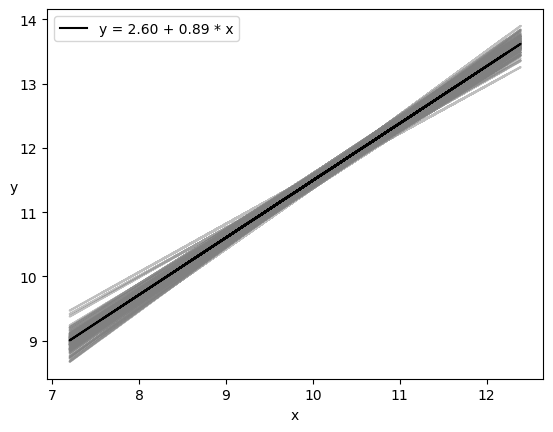

In [103]:
res = az.summary(trace_lin) #pandas DataFrame

alpha_m = res.loc['α']['mean']
beta_m  = res.loc['β']['mean']


trace_a = trace_lin['posterior']['α'][0].values
trace_b = trace_lin['posterior']['β'][0].values

draws = range(0, len(trace_lin['posterior']['α'][0]), 10)


plt.plot(x, trace_a[draws] + trace_b[draws]
         * x[:, np.newaxis], c='gray', alpha=0.5);

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x');

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend();


In [104]:
ppc = pm.sample_posterior_predictive(trace_lin, model=model_lin)

In [75]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

Text(0, 0.5, 'y')

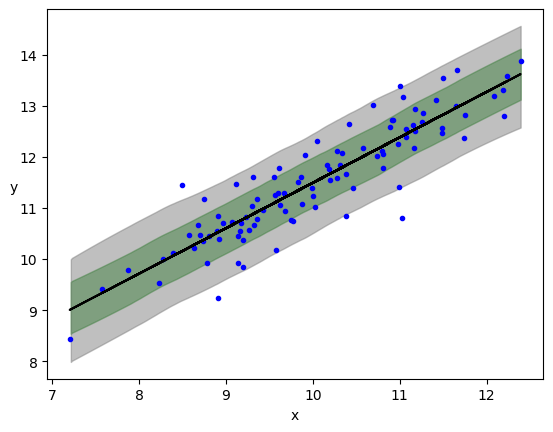

In [105]:
plt.plot(x, y, 'b.')


plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')


az.plot_hdi(x, ppc.posterior_predictive['y_pred'], hdi_prob=0.68, color='green')
az.plot_hdi(x, ppc.posterior_predictive['y_pred'], hdi_prob=0.95, color='gray')

plt.xlabel('x')
plt.ylabel('y', rotation=0)

### Comparison with Ordinary Least Squares

In [83]:
from scipy import stats

In [84]:
lreg = stats.linregress(x,y)

slope = lreg.slope
slope_err = lreg.stderr
interc = lreg.intercept
interc_err = lreg.intercept_stderr


res = az.summary(trace_lin)
alpha_m = res.loc['α']['mean']
alpha_s = res.loc['α']['sd']
beta_m  = res.loc['β']['mean']
beta_s = res.loc['β']['sd']

print("\nOLS:\nα= {:1.3} +/- {:1.3}".format(interc,interc_err))
print("β= {:1.3} +/- {:1.3}\n".format(slope,slope_err))
print("\nBayesLR:\nα= {:1.3} +/- {:1.3}".format(alpha_m,alpha_s))
print("β= {:1.3} +/- {:1.3}\n".format(beta_m,beta_s))


OLS:
α= 2.57 +/- 0.438
β= 0.892 +/- 0.0434


BayesLR:
α= 2.59 +/- 0.433
β= 0.89 +/- 0.043



## Robust Linear Regression

In [173]:
N = 10
x = np.random.normal(10,1,N)
eps = np.random.normal(0,0.5,size=N)

alpha_real = 2.5
beta_real = 0.9

y = alpha_real + beta_real*x

#Let's add an outlier
x_o = 10.0
y_o = 12.5

# the new dataset
xn = np.append(x,x_o)
yn = np.append(y,y_o)


# centering datasets
x = x-np.mean(x)
y = y-np.mean(y)

xn = xn-np.mean(xn)
yn = yn-np.mean(yn)

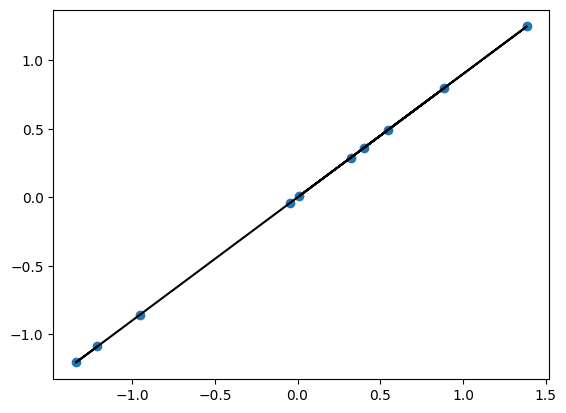

In [175]:
plt.scatter(x,y)
plt.plot(x,y,'k')

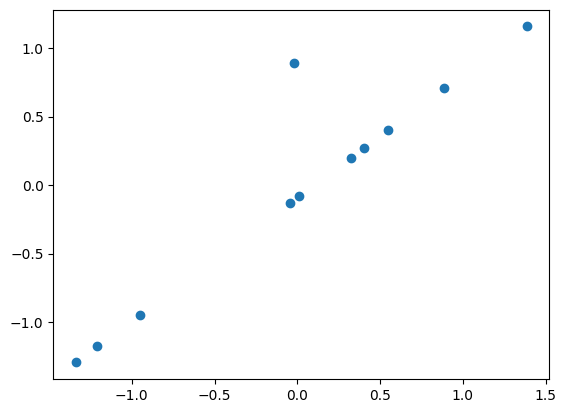

In [176]:
plt.scatter(xn,yn)

Now if you do a fit, the results of alpha and beta will be affected by the outlier point

In [177]:
lreg = stats.linregress(x,y)

slope = lreg.slope
slope_err = lreg.stderr
interc = lreg.intercept
interc_err = lreg.intercept_stderr

print("\nOLS:\nα= {:1.3} +/- {:1.3}".format(interc,interc_err))
print("β= {:1.3} +/- {:1.3}\n".format(slope,slope_err))


OLS:
α= -4.26e-16 +/- 0.0
β= 0.9 +/- 0.0



In [178]:
lreg = stats.linregress(xn,yn)

slope_n = lreg.slope
slope_err_n = lreg.stderr
interc_n = lreg.intercept
interc_err_n = lreg.intercept_stderr

print("\nOLS:\nα= {:1.3} +/- {:1.3}".format(interc_n,interc_err_n))
print("β= {:1.3} +/- {:1.3}\n".format(slope_n,slope_err_n))


OLS:
α= 1.61e-16 +/- 0.0958
β= 0.898 +/- 0.117



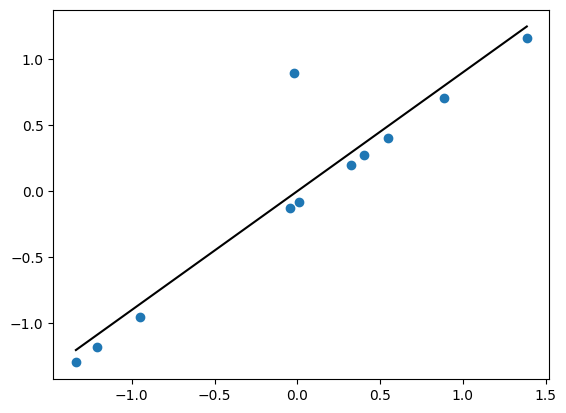

In [179]:
plt.scatter(xn,yn)

xp = np.linspace(np.min(xn),np.max(xn),100)

yp = interc_n + slope_n*xp

plt.plot(xp,yp,'k-')

In [182]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=0, sigma=0.2)
    β = pm.Normal('β', mu=0, sigma=1)
    #ϵ = pm.HalfNormal('ϵ', 3)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1) #a shifted exponential to avoid values of ν close to 0

    y_pred = pm.StudentT('y_pred', mu=α + β * xn,
                         sigma=0.1, nu=ν, observed=yn) #ϵ

    trace_t = pm.sample(2000, tune=1000, return_inferencedata=True)

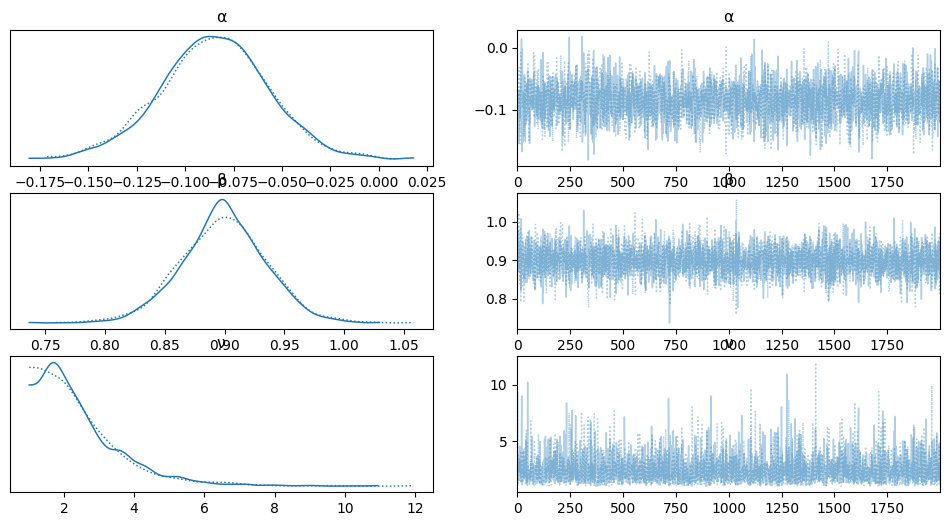

In [184]:
varnames = ['α', 'β', 'ν']
az.plot_trace(trace_t, var_names=varnames);

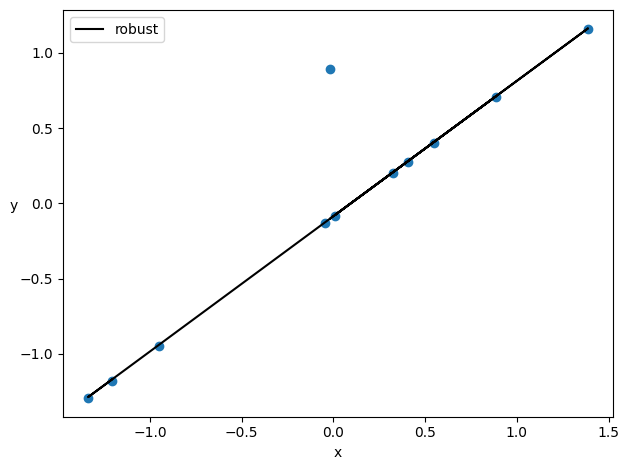

In [185]:
rest = az.summary(trace_t)

alpha_m = rest.loc['α']['mean']
beta_m  = rest.loc['β']['mean']
plt.plot(xn, alpha_m + beta_m * xn, c='k', label='robust')

plt.scatter(xn,yn)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()